# SAR

## Coordinates Distress Case

##### Given the information from Alarm Phone (AP) the following calculates the estimated rendezvous point of the SAR ship and the distress case (DC).  
##### There are two versions. The first only needs one set of coordinates from DC plus the speed and direction provided by AP, while the second requires two set of coordinates of the DC.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

The radius of the earth `radEarth` differs even at sea level due to the earth being an ellipsoid. We use one, arising at the latitude of the Medditeranean.
(https://rechneronline.de/earth-radius/)

`maxVelocityKn` is the velocity of the SAR ship in knots.

In [2]:
radEarth = 6365 # mediterranean; 6371 equator; 6356 North/South pole 
maxVelocityKn = 8.5 # knots
maxVelocity = maxVelocityKn*1852/60/1000 # km/min
#maxVelocity = maxVelocityKn
#velocityDCKn = 2 # knots
#velocityDC = velocityDCKn*1852/60/1000 # km/min

In [3]:
def latlon_to_cartesian(lat, lon, R=6371):
    """
    Transforms spherical coordinates to cartesian coordinates

    Parameters:
    lat: latitude
    lon: longitude
    R: radius of the earth

    Returns:
    x, y, z: cartesian coordinates
    """
    x = R * math.cos(lat) * math.cos(lon)
    y = R * math.cos(lat) * math.sin(lon)
    z = R * math.sin(lat)
    return x, y, z

In [4]:
def f(lat,lon):
    """
    Transforms spherical coordinates to cartesian coordinates on the earths radius

    Parameters:
    lat: latitude
    lon: longitude
    
    Returns:
    [x, y, z]: cartesian coordinates
    """
    x = np.cos(lat)*np.cos(lon)
    y = np.cos(lat)*np.sin(lon)
    z = np.sin(lat)
    return np.array([x,y,z])*radEarth

def finv(x,y,z):
    """
    Transforms cartesian coordinates to spherical coordinates on the earths radius

    Parameters:
    x, y, z: cartesian coordinates
    
    Returns:
    [lat, lon]: spherical coordinates
    """
    lat = np.arcsin(z/radEarth)
    lon = np.arctan2(y,x)
    return np.array([lat,lon])

In [5]:
def Ry(angle):
    """
    Clockwise rotation matrix about the positive y-axis by given angle

    Parameters:
    angle: angle of rotation

    Returns:
    matrix
    """
    return np.array([
        [np.cos(angle),0,np.sin(angle)],
        [0,1,0],
        [-np.sin(angle),0,np.cos(angle)]
    ])

def Rz(angle):
    """
    Clockwise rotation matrix about the positive z-axis by given angle

    Parameters:
    angle: angle of rotation

    Returns:
    matrix
    """
    return np.array([
        [np.cos(angle),-np.sin(angle),0],
        [np.sin(angle),np.cos(angle),0],
        [0,0,1]
    ])

In [6]:
def getRotation(lat,lon):
    """
    Rotation matrix along z- and y-axis such that lat,lon will be new north

    Parameters:
    lat: latitude
    lon: longitude

    Returns:
    matrix
    """
    lat = -lat + np.pi/2
    return np.array([
        [np.cos(-lat)*np.cos(-lon), -np.cos(-lat)*np.sin(-lon), np.sin(-lat)],
        [np.sin(-lon), np.cos(-lon), 0],
        [-np.sin(-lat)*np.cos(-lon),np.sin(-lat)*np.sin(-lon),np.cos(-lat)]
    ])

def getInverseRotation(lat,lon):
    """
    Rotation matrix along y- and z-axis such that lat,lon return from north

    Parameters:
    lat: latitude
    lon: longitude

    Returns:
    matrix
    """
    lat = -lat + np.pi/2
    return np.array([
        [np.cos(lat)*np.cos(lon), -np.sin(lon), np.sin(lat)*np.cos(lon)],
        [np.cos(lat)*np.sin(lon), np.cos(lon), np.sin(lat)*np.sin(lon)],
        [-np.sin(lat),0,np.cos(lat)]
    ])

In [30]:
def transform(lat,lon,boatLatLon):
    """
    Rotates boat to the north pole and takes the other coordinates along, then projects to the plane by forgetting the z-axis

    Parameters:
    lat: latitude
    lon: longitude
    boatLatLon: latitude and longitude of boat

    Returns:
    cartesian coordinates of lat, lon in plane with respect to zero, the position of boatLatLon 
    """
    rotation = getRotation(*boatLatLon)
    xyz = f(lat,lon)
    print("xyz: ",xyz)
    return (rotation @ xyz)[:2]

def inverseTransform(x,y,boatLatLon):
    """
    Recovers z-axis and rotates boat back from the north pole to original position, while taking the other coordinates along.

    Parameters:
    x,y: cartesian coordinates in the plane
    boatLatLon: latitude and longitude of boat

    Returns:
    spherical coordinates of rotated x, y 
    """
    z = (radEarth**2-x**2-y**2)**.5
    xyz = np.array([x,y,z])
    
    rotation = getInverseRotation(*boatLatLon)
    rotatedXYZ = rotation@xyz
    print("rotatedXYZ:",rotatedXYZ)
    return finv(*rotatedXYZ)

In [8]:
def getP(p1,p2,t1,t2):
    """
    Linear interpolation of two given points between given interval

    Parameters:
    p1, p2: points in plane
    t1, t2: time intervals

    Returns:
    function
    """
    def p(t):
        return (t-t1)/(t2-t1)*p2 - (t-t2)/(t2-t1)*p1
    return p

def getQ(q0,t0,d):
    """
    Linear equation of motion with constant velocity

    Parameters:
    q0: initial position in the plane
    t0: initial time
    d: direction of motion, unit vector in the plane

    Returns:
    function
    """
    def q(t):
        return maxVelocity*(t-t0)*d+q0
    return q

def getPdc(p1,t1,ddc,vdc):
    """
    Linear equation of motion with constant velocity

    Parameters:
    p1: initial position in the plane
    t1: initial time
    ddc: direction of motion
    vdc: velocity of motion

    Returns:
    function
    """
    def pdc(t):
        return vdc*ddc/np.linalg.norm(ddc)*(t-t1)+p1
    return pdc

In [9]:
def simulate2ndDc(p1latlon,t1,bearing,vdc,t2=10):
    """
    Calculate the position after moving in a given direction
    
    Parameters:
    p1latlon: initial position (radians)
    t1:       initial time
    bearing:  direction (degrees)
    vdc:      velocity
    
    Returns:
    second position (radians)
    """
    lat1,lon1 = p1latlon
    relDist = vdc*(t2-t1)/radEarth
    bearingRad = bearing/180*np.pi
    lat2 = np.arcsin(np.sin(lat1)*np.cos(relDist) + np.cos(lat1)*np.sin(relDist)*np.cos(bearingRad))
    lon2 = lon1 + np.arctan2(np.sin(bearingRad)*np.sin(relDist)*np.cos(lat1), np.cos(relDist) - np.sin(lat1)*np.sin(lat2))
    return np.array([lat2,lon2])

In [10]:
def getTime(boat, d1, d2,t0,t1,t2):
    """
    Solves for the time when the boat and estimated trajectory of DC meet

    Parameters:
    boat: planar coordinates of boat
    d1: planar coordinates of first distress case
    d2: planar coordinates of second distress case
    t0: time of boat starting the bearing
    t1: time when DC was at d1
    t2: time when DC was at d2

    Returns:
    time of rendezvous
    """
    a = maxVelocity**2*(t2-t1)**2 - (d2[0]-d1[0])**2 - (d2[1]-d1[1])**2
    b = -maxVelocity**2*t0*(t2-t1)**2 - (d2[0]-d1[0])*(-t1*d2[0]+t2*d1[0]-(t2-t1)*boat[0]) - (d2[1]-d1[1])*(-t1*d2[1]+t2*d1[1]-(t2-t1)*boat[1])
    b *= 2
    c = maxVelocity**2*t0**2*(t2-t1)**2 - (-t1*d2[0]+t2*d1[0]-(t2-t1)*boat[0])**2 - (-t1*d2[1]+t2*d1[1]-(t2-t1)*boat[1])**2
    
    tx1,tx2 =  (-b+np.sqrt(b**2-4*a*c))/2/a,(-b-np.sqrt(b**2-4*a*c))/2/a
    return max(tx1,tx2)


def getTimeSingleDC(boat, d1, t0, t1, vdc, ddc):
    """
    Solves for the time when the boat and estimated trajectory of DC meet

    Parameters:
    boat: planar coordinates of boat
    d1: planar coordinates of distress case
    t0: time of boat starting the bearing
    t1: time when DC was at d1
    vdc: velocity of DC
    ddc: bearing of DC in planar coordinates
    
    Returns:
    time of rendezvous
    """
    a = maxVelocity**2 - vdc**2/np.linalg.norm(ddc)**2*(ddc[0]**2 + ddc[1]**2)
    b = -maxVelocity**2*t0 + vdc**2/np.linalg.norm(ddc)**2 * t1*(ddc[0]**2+ddc[1]**2) - vdc/np.linalg.norm(ddc)*(ddc[0]*(d1[0]-boat[0]) + ddc[1]*(d1[1])-boat[1])
    b *= 2
    c = maxVelocity**2*t0**2 - vdc**2/np.linalg.norm(ddc)**2*(ddc[0]**2 + ddc[1]**2) + 2*vdc/np.linalg.norm(ddc)*t1*(ddc[0]*(d1[0]-boat[0]) + ddc[1]*(d1[1])-boat[1]) - (d1[0]-boat[0])**2 - (d1[1]-boat[1])**2
    
    tx1,tx2 =  (-b+np.sqrt(b**2-4*a*c))/2/a,(-b-np.sqrt(b**2-4*a*c))/2/a
    return max(tx1,tx2)

In [11]:
def getVelocity(p1,p2,t1,t2):
    """
    Calculates velocity of DC

    Parameters:
    p1, p2: positons of DC
    t1, t2: time DC is at p1, p2

    Returns:
    velocity DC
    """
    return np.linalg.norm(p2-p1)/(t2-t1)

In [12]:
def getDir(t,q0,p1,p2,t0,t1,t2):
    """
    Calculates the direction the boat needs to take to reach the rendezvous point.

    Parameters:
    t: time to reach the rendezvous point
    q0: initial position of boat
    p1, p2: positons of DC
    t0: time boat is at q0
    t1, t2: time DC is at p1, p2

    Returns:
    direction in the plane
    """
    d =  1/maxVelocity/(t-t0)*(1/(t2-t1)*(t*(p2-p1)+t2*p1-t1*p2)-q0)
    return d

def getDirSingleDC(t,q0,p1,t0,t1,vdc,ddc):
    """
    Calculates the direction the boat needs to take to reach the rendezvous point.

    Parameters:
    t: time to reach the rendezvous point
    q0: initial position of boat
    p1: positon of DC
    t0: time boat is at q0 
    t1: time DC is at p1
    vdc: velocity of DC
    ddc: bearing of DC in planar coordinates

    Returns:
    direction in the plane
    """
    d =  1/maxVelocity/(t-t0)*(vdc/np.linalg.norm(ddc)*(t-t1)*ddc + p1 - q0)
    return d

To calculate the bearing, see https://www.movable-type.co.uk/scripts/latlong.html

In [13]:
def getBearing(latLon1,latLon2):
    """
    Calculates bearing for the boat to reach the rendezvous.

    Parameters:
    latLon1: latitude and longitude of boat
    latLon2: latitude and longitude of redezvous

    Returns:
    angle: initial bearing angle in radians
    """
    deltaLat = latLon2[1]-latLon1[1]
    x = np.sin(deltaLat)*np.cos(latLon2[0])
    y = np.cos(latLon1[0])*np.sin(latLon2[0])-np.cos(latLon2[0])*np.sin(latLon1[0])*np.cos(deltaLat)
    #print(deltaLat)
    #print(x)
    #print(y)
    return np.arctan2(x, y)

def getDirFromBearing(angle):
    """
    Calculates the direction vector from given Bearing angle.

    Parameters:
    angle: Bearing in degrees

    Returns:
    direction vector
    """
    angle = angle/180*np.pi
    lat = np.cos(angle)
    lon = np.sin(angle)
    return np.array([lat, lon])

def getBearingFromDir(d):
    x,y = d
    return np.arctan2(x,y)

In [14]:
def logData(boat,d1,d2,q0,p1,p2,t1,t2,tx,target,intersection):
    """
    Displays velocities of SAR boat and DC, the time it takes to reach the rendezvous as well as the distance.
    It further displays the positions in degree and distance in km with the boat as reference point of the boat itself, the distress case and rendezvous point.

    Parameters:
    boat: latitude and longitude of boat
    d1, d2: latitude and longitude of first and second DC
    qo, p1, p2: planar coordinates of boat, first and second DC
    t1, t2, tx: time when DC is as p1, p2 and intersection
    target, intersection: latitude and longitude respectively planar coordinates of intersection point
    """
    print("maxVelocity (km/h):",round(maxVelocity*60,3))
    print("disVelocity: (km/h)",round(getVelocity(d1,d2,t1,t2)*60000,3))
    
    print("")
    
    print("times (h):",round(tx/60,3))
    print("Distance traveled (km):",round(maxVelocity*tx,3))
    
    print("")
    for i in range(4):
        latLon = [boat,d1,d2,target][i]*180/np.pi
        xy = [q0,p1,p2,intersection][i]
        name = ["Boat","D1","D2","Intersection"][i]
        print(name+" Lat-Lon: (deg)",latLon[0],latLon[1])
        print(name+" XY:      (km) ",round(xy[0],3),round(xy[1],3))
        print()


def logDataSingleDC(boat,d1,vdc,q0,p1,t1,tx,target,intersection):
    """
    Displays velocities of SAR boat and DC, the time it takes to reach the rendezvous as well as the distance.
    It further displays the positions in degree and distance in km with the boat as reference point of the boat itself, the distress case and rendezvous point.
    
    Parameters:
    boat: latitude and longitude of boat
    d1: latitude and longitude of DC
    qo, p1: planar coordinates of boat and DC
    t1, tx: time when DC is as p1 and intersection
    target, intersection: latitude and longitude respectively planar coordinates of intersection point
    """
    print("maxVelocity (km/h):",round(maxVelocity*60,3))
    print("disVelocity: (km/h)",round(vdc*60,3))
    
    print("")
    
    print("times (h):",round(tx/60,3))
    print("Distance traveled (km):",round(maxVelocity*tx,3))
    
    print("")
    for i in range(3):
        latLon = [boat,d1,target][i]*180/np.pi
        xy = [q0,p1,intersection][i]
        name = ["Boat","DC","Intersection"][i]
        print(name+" Lat-Lon: (deg)",latLon[0],latLon[1])
        print(name+" XY:      (km) ",round(xy[0],3),round(xy[1],3))
        print()

Here we provide data of two examples to test, what we have done so far.  
The first is one in Göttingen, the second in the Med.

In [15]:
# Göttingen
boat = np.array((51.535686, 9.915863))/180*np.pi
d1   = np.array((51.552215, 9.950271))/180*np.pi
d2   = np.array((51.548812, 9.952126))/180*np.pi
t0 = 0
t1 = -40
t2 = -10
goettingen = [boat,d1,d2,t0,t1,t2]

# Göttingen Single DC
boat = np.array((51.535686, 9.915863))/180*np.pi
d1   = np.array((51.552215, 9.950271))/180*np.pi
t0 = 0
t1 = -40
ddc = getDirFromBearing(90)
vdc = 2*1852/60/1000 # km/min
goettingenSingleDC = [boat,d1,t0,t1,ddc,vdc]

In [17]:
# Mittelmeer
boat = np.array((34.729698, 12.031768))/180*np.pi
d1   = np.array((33.905521, 14.141110))/180*np.pi
d2   = np.array((34.003924, 14.057971))/180*np.pi
t0 = 0
t1 = -300
t2 = -10
mittelmeer = [boat,d1,d2,t0,t1,t2]

# Mittelmeer
boat = np.array((34.729698, 12.031768))/180*np.pi
d1   = np.array((33.905521, 14.141110))/180*np.pi
t0 = 0
t1 = -300
ddc = np.array((1, -0.6))
ddc /= np.linalg.norm(ddc)
vdc = 1.7*1852/60/1000 # km/min
mittelmeerSingleDC = [boat,d1,t0,t1,ddc,vdc]

Then we test the procedure developed above:

In [18]:
boat,d1,d2,t0,t1,t2 = goettingen
q0,p1,p2 = (transform(*latLon,boat) for latLon in [boat,d1,d2])
tx = getTime(q0,p1,p2,t0,t1,t2)
d = getDir(tx,q0,p1,p2,t0,t1,t2)
q = getQ(q0,t0,d)
rendezvousXY = q(tx)
rendezvousLatLon = inverseTransform(*rendezvousXY,boat)
bearing = getBearing(boat,rendezvousLatLon)

logData(boat,d1,d2,q0,p1,p2,t1,t2,tx,rendezvousLatLon,rendezvousXY)

rotatedXYZ: [3898.68921146  684.17630493 4984.5110308 ]
maxVelocity (km/h): 15.742
disVelocity: (km/h) 0.135

times (h): 0.181
Distance traveled (km): 2.857

Boat Lat-Lon: (deg) 51.535686000000005 9.915863
Boat XY:      (km)  0.0 0.0

D1 Lat-Lon: (deg) 51.552215 9.950271
D1 XY:      (km)  -1.837 2.377

D2 Lat-Lon: (deg) 51.548812000000005 9.952126
D2 XY:      (km)  -1.459 2.505

Intersection Lat-Lon: (deg) 51.54644257441977 9.953417417901909
Intersection XY:      (km)  -1.196 2.594



It is quite usefull to check, whether this makes sense on a map, e.g. https://www.google.de/maps or in Google Earth.

The following diagram checks, whether the SAR ship `boat` and the DC `distress` actually meet in a straight line.

In [19]:
p = getP(p1,p2,t1,t2)
q = getQ(q0,t0,d)
ts = np.linspace(-30,tx,100)
ps = np.array([p(t) for t in ts])
qs = np.array([q(t) for t in ts])

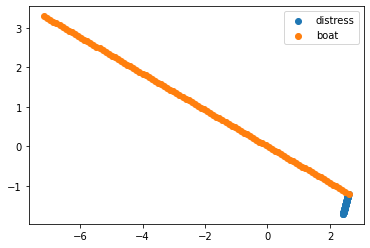

In [20]:
plt.scatter(ps[:,1],ps[:,0],label="distress")
plt.scatter(qs[:,1],qs[:,0],label="boat")
plt.legend()
#plt.axis("off")
plt.show()

The same is done with the procedure when only a single coordinate is known. The problem here is that through the rotations, the initial bearing is altered in an unwanted way. It could be resolved, but it is also possible to just add a virtual second coordinate via the equation of motion and then fall back to the first method.

In [34]:
boat,d1,t0,t1,ddc,vdc = mittelmeerSingleDC
q0,p1 = (transform(*latLon,boat) for latLon in [boat,d1])
tx = getTimeSingleDC(q0,p1,t0,t1,vdc,ddc)
d = getDirSingleDC(tx,q0,p1,t0,t1,vdc,ddc)
pdc = getPdc(p1,t1,ddc,vdc)
rendezvousXY = pdc(tx)
rendezvousLatLon = inverseTransform(*rendezvousXY,boat)
bearing = getBearing(boat,rendezvousLatLon)

logDataSingleDC(boat,d1,vdc,q0,p1,t1,tx,rendezvousLatLon,rendezvousXY)

xyz:  [5116.15277666 1090.43703771 3626.17606201]
xyz:  [5122.60469748 1290.61745944 3550.55667281]
rotatedXYZ: [5156.94297257 1267.01913019 3509.10625393]
maxVelocity (km/h): 15.742
disVelocity: (km/h) 3.148

times (h): 13.667
Distance traveled (km): 215.149

Boat Lat-Lon: (deg) 34.729698 12.031768
Boat XY:      (km)  0.0 -0.0

DC Lat-Lon: (deg) 33.90552099999999 14.141109999999998
DC XY:      (km)  89.516 194.438

Intersection Lat-Lon: (deg) 33.457126269632596 13.803692964660513
Intersection XY:      (km)  139.912 164.2



In [22]:
p1c = getPdc(p1,t1,ddc,vdc)
q1c = getQ(q0,t0,d)
ts = np.linspace(-0,tx,100)
ps1c = np.array([p1c(t) for t in ts])
qs1c = np.array([q1c(t) for t in ts])

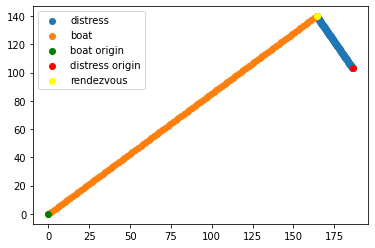

In [24]:
plt.scatter(ps1c[:,1],ps1c[:,0],label="distress")
plt.scatter(qs1c[:,1],qs1c[:,0],label="boat")
plt.scatter(qs1c[0,1],qs1c[0,0],label="boat origin",color="green")
plt.scatter(ps1c[0,1],ps1c[0,0],label="distress origin",color="red")
plt.scatter(rendezvousXY[1],rendezvousXY[0],label="rendezvous",color="yellow")
plt.legend()
#plt.axis("off")
plt.show()